# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [2]:
df_path = 'labels.csv'
img_path = 'final_files'
parent_path = '/datasets/faces/'

if os.path.exists(df_path):
    df_ages = pd.read_csv(df_path)
elif os.path.exists(parent_path+df_path):
    df_ages = pd.read_csv(parent_path+df_path)
else:
    print('Something is wrong')

In [3]:
df_ages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df_ages.shape

(7591, 2)

In [5]:
df_ages.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


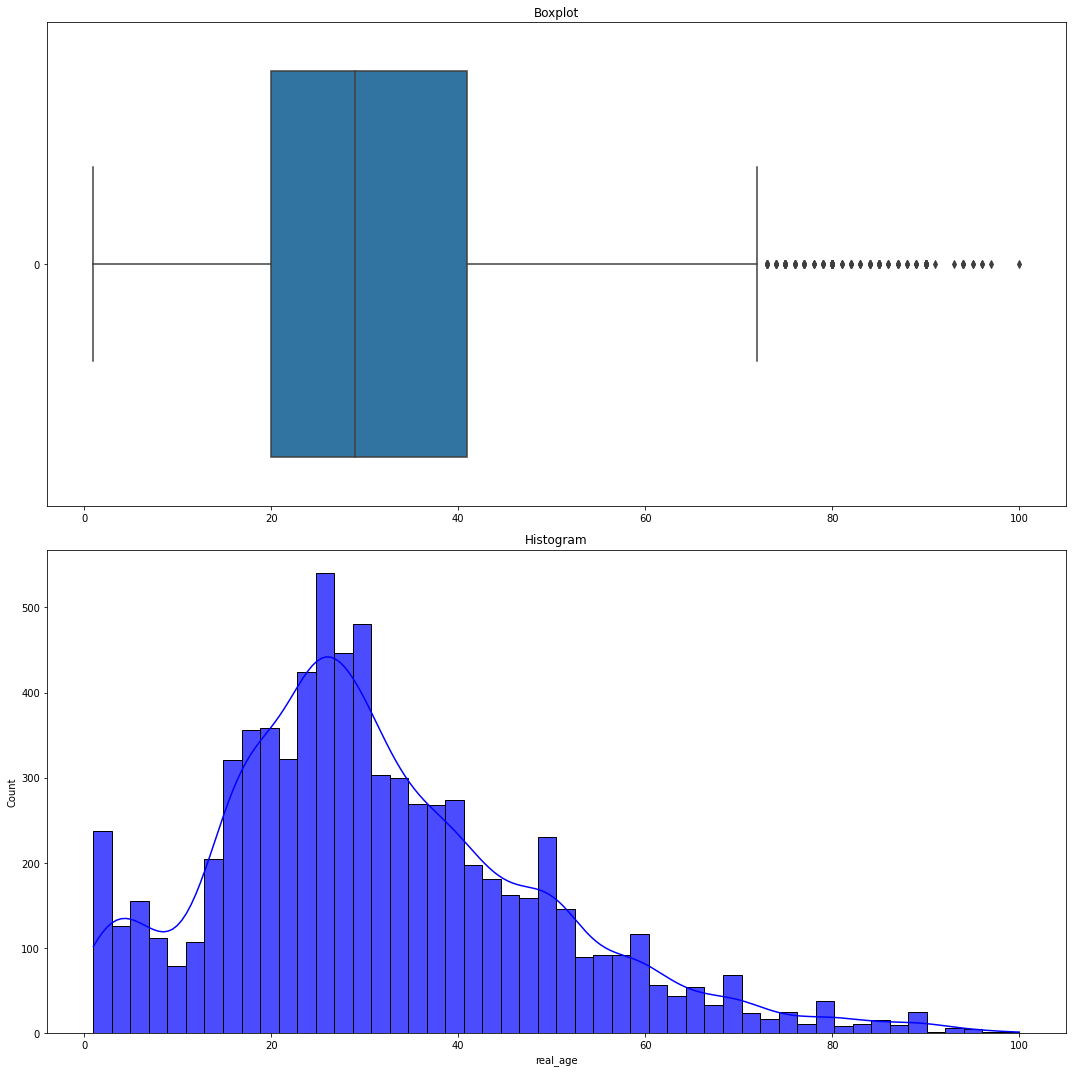

In [6]:
describe = df_ages['real_age'].describe()
print(describe)
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)  
sns.boxplot(data=df_ages['real_age'], orient='h')
plt.title('Boxplot')
plt.subplot(2, 1, 2)  
sns.histplot(data=df_ages['real_age'],kde=True, bins=50, 
             color='blue', alpha=0.7)
plt.title('Histogram')
plt.tight_layout()
plt.show()

In [10]:
if os.path.exists(parent_path+img_path):
    datagen = ImageDataGenerator()
    datagen_flow = datagen.flow_from_dataframe(
        df_ages,
        directory = parent_path+img_path,
        x_col='file_name',  
        y_col='real_age',
        batch_size=15,
        class_mode = 'raw',
        shuffle=False,
        seed=12345
)
else:
    print('Something is wrong')

Found 7591 validated image filenames.


In [11]:
features, target = next(datagen_flow)
features[0].shape

(256, 256, 3)

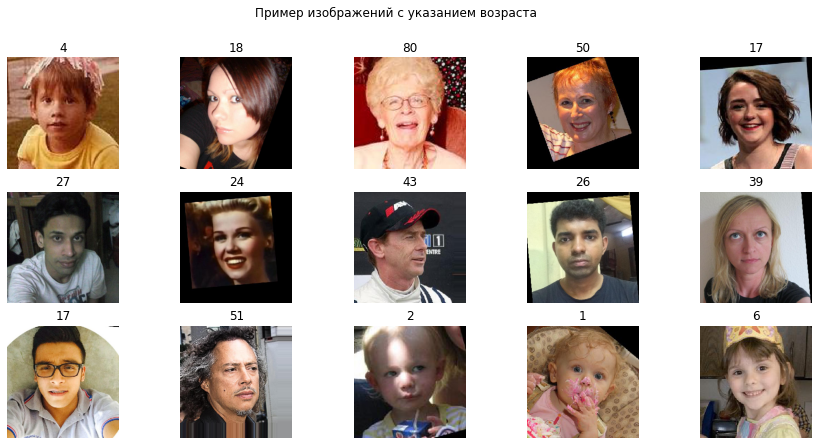

In [16]:
plt.figure(figsize=(15, 7))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(image.array_to_img(features[i]))
    plt.title(f'{target[i]}')
    plt.axis('off')
plt.suptitle('Пример изображений с указанием возраста')
plt.show()

<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
    
Вывод:

В выборке представлено 7591 изображений в формате (256, 256, 3).
    
Больше всего присутствует изображений людей возраста 18-40 лет. Так же присутствуют фотографии для возраста 0-10 лет. Как следствие модель будет плохо обобщаться на возраст 40+.
    
В выборке представлены всевозможные фотографии, однако лица на них центрированы и довернуты. 
    
Для достижения качественного предсказания на валидации можно проводить следующую аугментацию: горизонтальное отражение, изменения яркости, поворот на небольшой угол(20), масштабирование.

    

## Обучение модели

```python

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import  Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd


def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       rotation_range=20,
                                       rescale=1/255.,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        brightness_range=[0.7, 1.3]
                                    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + '/labels.csv'),
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, 
                                   rescale=1/255.)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + '/labels.csv'),
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=(256, 256, 3), weights='imagenet',
                    include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0003), loss='mean_squared_error', 
              metrics=['mean_absolute_error']) 
    print(model.summary())
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model 

```

Для модели использовалась следующая архитектура:

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
=================================================================
Total params: 24,112,513
Trainable params: 24,059,393
Non-trainable params: 53,120
_________________________________________________________________


Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 129s - loss: 202.3026 - mean_absolute_error: 10.6690 - val_loss: 560.7040 - val_mean_absolute_error: 18.6370
Epoch 2/20
178/178 - 121s - loss: 126.5031 - mean_absolute_error: 8.5361 - val_loss: 404.2737 - val_mean_absolute_error: 15.0592
Epoch 3/20
178/178 - 122s - loss: 103.9736 - mean_absolute_error: 7.7127 - val_loss: 299.7542 - val_mean_absolute_error: 12.8805
Epoch 4/20
178/178 - 122s - loss: 87.3914 - mean_absolute_error: 7.1219 - val_loss: 169.1840 - val_mean_absolute_error: 9.8988
Epoch 5/20
178/178 - 121s - loss: 82.8504 - mean_absolute_error: 6.9408 - val_loss: 106.2511 - val_mean_absolute_error: 7.9044
Epoch 6/20
178/178 - 121s - loss: 73.6953 - mean_absolute_error: 6.4944 - val_loss: 82.9732 - val_mean_absolute_error: 6.8516
Epoch 7/20
178/178 - 122s - loss: 70.2185 - mean_absolute_error: 6.4019 - val_loss: 79.1257 - val_mean_absolute_error: 6.6591
Epoch 8/20
178/178 - 122s - loss: 67.0982 - mean_absolute_error: 6.2144 - val_loss: 92.4019 - val_mean_absolute_error: 7.4201
Epoch 9/20
178/178 - 122s - loss: 60.4315 - mean_absolute_error: 5.9404 - val_loss: 108.3704 - val_mean_absolute_error: 7.6804
Epoch 10/20
178/178 - 121s - loss: 54.3883 - mean_absolute_error: 5.6215 - val_loss: 92.9224 - val_mean_absolute_error: 7.0361
Epoch 11/20
178/178 - 122s - loss: 48.1608 - mean_absolute_error: 5.3257 - val_loss: 89.9155 - val_mean_absolute_error: 6.9113
Epoch 12/20
178/178 - 122s - loss: 50.4059 - mean_absolute_error: 5.4297 - val_loss: 74.4718 - val_mean_absolute_error: 6.3799
Epoch 13/20
178/178 - 121s - loss: 43.9382 - mean_absolute_error: 5.0580 - val_loss: 69.0809 - val_mean_absolute_error: 6.2560
Epoch 14/20
178/178 - 122s - loss: 40.9659 - mean_absolute_error: 4.8995 - val_loss: 82.7455 - val_mean_absolute_error: 6.5991
Epoch 15/20
178/178 - 122s - loss: 41.5287 - mean_absolute_error: 4.9139 - val_loss: 113.5113 - val_mean_absolute_error: 7.8942
Epoch 16/20
178/178 - 121s - loss: 36.9864 - mean_absolute_error: 4.6900 - val_loss: 77.9085 - val_mean_absolute_error: 6.4074
Epoch 17/20
178/178 - 122s - loss: 33.3545 - mean_absolute_error: 4.4619 - val_loss: 69.9858 - val_mean_absolute_error: 6.2106
Epoch 18/20
178/178 - 122s - loss: 33.1884 - mean_absolute_error: 4.4128 - val_loss: 79.3066 - val_mean_absolute_error: 6.7665
Epoch 19/20
178/178 - 121s - loss: 31.6190 - mean_absolute_error: 4.2745 - val_loss: 78.8431 - val_mean_absolute_error: 6.4623
Epoch 20/20
178/178 - 121s - loss: 30.1379 - mean_absolute_error: 4.2617 - val_loss: 77.6860 - val_mean_absolute_error: 6.3242


60/60 - 10s - loss: 77.6860 - mean_absolute_error: 6.3242
Test MAE: 6.3242

```

## Анализ обученной модели

Было представлено 7591 изображений в формате (256, 256, 3).

Для них была проведена аугментация: нормализация RGB к [0-1], доворот до 20 градусов, масштабирование до 20%, горизонтальное отражение и изменение яркости в диапазоне [0.7-1.3].

Для решения задачи предсказания возраста по картинке была использована модель с рахитектурой ResNet50 обученной на ImageNet где последний слой заменился на дропаут, GAP, полносвязный слой с 512 нейронами и активацией ReLu и полносвязный слой с одним нейроном и активацией ReLu.

Обучение производилось на оптимизаторе Adam с шагом 0.0003 с функцией потерь MSE, метрика качества - MAE.

Итоговая MAE после 20 эпох:

**train** - 4.2617

**test** - 6.3242

Модель не переобучилась и работает адекватно.

Ошибку 6.3242 можно признать небольшой в сравнении с результатом 5.4 в  [статье](https://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf).

Для улучшения результата можно изменить архитектуру в сторону увеличения сверточных и полносвязных слоев, однако это может повлечь переобучение. Потому также требуется затюнить гиперпараметры, например: дропаута и колва эпох обучения. Для увеличения обобщающей способности можно увеличить количество обучающих данных.

Также можно использовать метод active learning. В даном случае можно проверить работу модели на обучающем наборе и определить на каких приемрах модель больше всего ошибается. 

Используя различную аугментацию для обучающей выборки (без дообучения) можно отобрать примеры, где модель дает наиболее различный результат. С помощью отобранных примеров  можно определить из-за чего ошибается модель.
